<a href="https://colab.research.google.com/github/ludwigwittgenstein2/Research/blob/master/Multilayer_Perceptron_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Why Use Neural Networks? 

Classical Machine Learning Techniques

-SVM
-Random Forest
-KNN

These work with structured data, 
where inputs have clear meaning

How about Unstructured dataset? 

-Well, for that, 
-Images
-Raw Speech Waveforms
-Wearable Sensor Data

-Neural Networks do Feature Learning
-Where Summarizes are learnt


## Multilayer Perceptron

-We can use Multilayer Perceptron

to perform image classification

-In Previous example, 
We saw how we used single layer Perceptron to predict labels

- Multilayer Perceptron is basically a feedforward network







##What is inside Multilayer Perceptron?

Input layer: the raw input data

Hidden layer(s): sequences of sets of functions

-To apply to either inputs or outputs of previous hidden layers

Output layer: final function or set of functions.

#When should we use Multilayer Perceptron? 

-When we know little 

-About Structure of Problem

-MLP is way of learning structure

-Increasing Depth, Width

-Increases flexibility 

-Function 

## What is Neuron? 

-Single Function
-Takes Input 
-Applies Activation Function


#Simple Neural Network

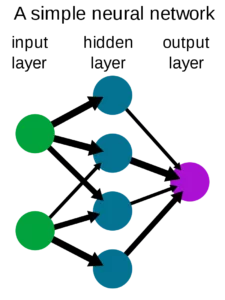

## Multilayer Perceptron 

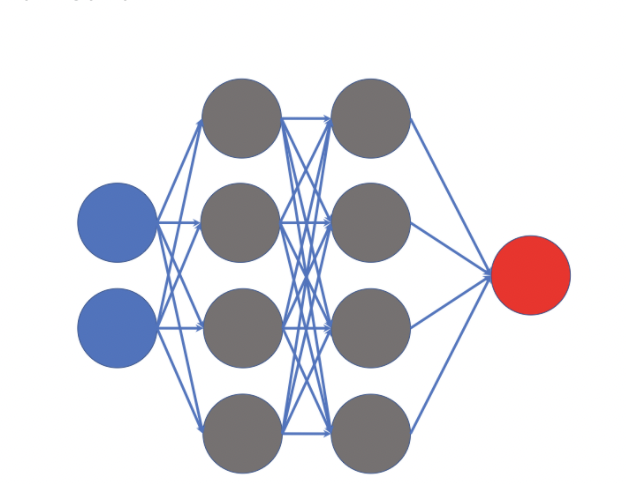

In [ ]:
#PyTorch functinality
#torch.nn Neural Network functionality
#torch.optim for optimizer 
#torch.utils.data for dataset handling
#torchvision.transforms for data augmentation
#torchvision.datasets for loading dataset
#sklearn's metrics confusion matrix 
#sklearn's decomposition and manifold for visualizing neural network
#In Two-Dimension, Matlobplot for plotting

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [ ]:
#We give random seed for reproducibility results

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
#MNIST dataset and save in folder called .data
#We load our dataset

ROOT = '.data'

train_data = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
#We want to Normalize the data - why? 
#Allows our model to train faster
#Help them avoid local minima
#Train more reliably 

#How to Normalize? 

#We calculate Mean and SD only from training set and not test set


In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: .data
    Split: Train

In [ ]:
#Standard devation: How much variation from Mean exists?
#Mean is Average

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [ ]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


In [ ]:
# Now We have Mean and Standard Deviation 

# We want to apply them in our dataset 

#How do we use them? 

#We use Torchvision transforms

#Transform states how our data is to be processed and augmented

# Data augmentation invovles manipulating available training data

#So we can artificially create more training examples

#transforms.Compose - to build list of transformations to apply to image


#transforms.RandomRotation - randomly rotates image between (-x, +x)
#transforms.RandomCrop first adds padding around our image
#ToTesnor - Convert from PIL image into PyTorch tensor
#Normalize -this subtracts the mean and divides by the standard deviations given


In [ ]:
#Train transform - created more examples for our model to train on
#Test transform - normalized

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean], std = [std])
                                     ])

In [ ]:
#Train Data and Test Data

train_data = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

test_data = datasets.MNIST(root = ROOT, 
                           train = False, 
                           download = True, 
                           transform = test_transforms)

In [ ]:
#Length of Dataset
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [ ]:
#Loading Images 
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.axis('off')

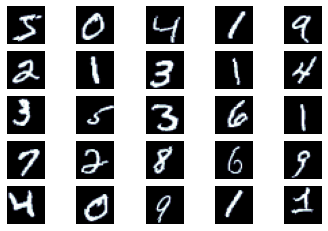

In [ ]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]] 

plot_images(images)

In [ ]:
#MNIST comes with training and test set
#MNIST data does not come with validation set

#We use validation set 

#to check how well our model performs on unseen data

#Validation set is from 10% of data

#We don't take validation set from TEST SET 

#In Research Papers, we use test set, and we use with same test set

In [ ]:
# We define exact number of examples, 
#we want in each split of training/validation set

VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [ ]:
#We use random_split to take a random 10% of training set to use as
#validation set
train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [ ]:

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


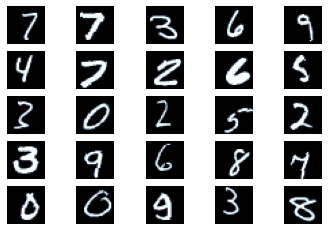

In [ ]:
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]] 

plot_images(images)

In [ ]:
#Validation set is subset of training set
#When we change transform of one, by default Torchvision will change
#others, we use deepcopy of validation data

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

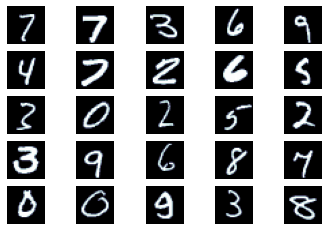

In [ ]:
# We display the same image to double check if there are the same

N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]] 

plot_images(images)

In [ ]:
#We define DataLoader for training/validation/test set
#We iterate over these and they yield batches of images and labels
#We shuffle our training set
#We use it for Stochastic Gradient Descent

#Normal Gradient Descent runs through entire dataset, computationally 
#expensive

#SGD is variant of Optimization Algorithm
#Datset is shuffled and partitioned into m examples
#And it picks up random pick example 




In [ ]:
#We Shuffle our training set for SGD
#We want each batch to be different between epochs
#Batch Size is number of samples propagated through the network
#Eg: If we have 1050 training samples
#If we give Batch Size equal to 100, it takes 1st to 100th from
#Trainign set


#So Why Care or use this?
#Less memory
#Networks train faster with mini-batches

#Disadvantage
#Smaller the batch size
#Less the accuracy or estimate the gradient will be
#

BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [ ]:
#We Define the Model

#Our Model will be a Neural Network with Multilayer Perceptron

# with two hidden layers


#We don't use the activation function on input directly or on output
#eg. F.relu(x)

In [ ]:
#We flatten our 1x 28x 28 (Image Size )
#1 Color Channel, 28 pixels heights and width
#Image into 784 Element Vector called 784 Features
#We Flatten our input as MLP that cannot handle two or three dimensional data

#And 784 dimensional input is passed through first hidden layer
#To transform to 250 dimensions

#Another Hidden Layer will transform it to 100 Dimensions

#Output Dimension should be equal to number of classes within our data

#We have 0-9, ten digits

#Out Output will be 10 dimensions

#So from 784 to 250, 250 to 100 and 100 to 10 dimension

#Is done by Linear Layers 

#Known as Fully Connected Layers 

#Each connection between neuron in one layer and another has weight
#Associated with it

#Neuron applies Activation function to this weighted sum

#Activation function is non-linear function

#That allows Neural Networks to learns non-linear functions 
#between input and output




In [ ]:
#Why did we use 250 hidden deminsions and 100 elements? 

#General idea is that neural networks extract features from data 
#Layers closer to input learn to extract general features
#Later Layers combine features extracted from previous later into high level features


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)
        
    def forward(self, x):
        
        #x = [batch size, height, width]
        
        batch_size = x.shape[0]

        x = x.view(batch_size, -1)
        
        #x = [batch size, height * width]
        
        h_1 = F.relu(self.input_fc(x))
        
        #h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        #h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        
        #y_pred = [batch size, output dim]
        
        return y_pred, h_2

In [ ]:
#We define our model by creating instance of it
#Setting Correct Input and Output dimensions 
#We create small function to calculate number of trainable paramaters

#(Weights and Biases)

#

In [ ]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [ ]:
# First Layer has 784 neurons connected to 250 neurons
# SO, 784 *250 weighted connection plus 250 bias terms

#Second Layer has 250 neurons connected to 100 neurons
#So, 250* 100 weighted Connections plus 100 bias terms

#Third layer has 100 neurons connected to 10 neurons
#100*10 weighted connections plus 10 bias terms

#So: 784⋅250+250+250⋅100+100+100⋅10+10=222,360



In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


In [ ]:
#Next, We Training the Model 

#We define the Optimizer 

#So, what is the Optimizer? 

#It's the alogrithm, that we use to update paramaters of our model 

#So, How are Neural Networks Trained? 

#1. Pass a Batch of Data through our Model 

#2. Calculate Loss of our Batch

#3. Compare our Model's Prediction against actual Lables 


#4. Calculate Gradient of each of our parameters with respect to Loss

#5. Update each of our parameter 

#6. By Subtracting their gradient multiplied by small learning rate parameter





In [ ]:
#We use Adam Algorithm 
#With default Parameters to update our model 




In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
#We define Criterion
#In PyTorch, Criteria is name for loss/cost/error function

#This function will take our model's prediction with actual lables 
#And compute loss/cost/error of our model with current parameters

In [ ]:


criterion = nn.CrossEntropyLoss()

In [ ]:
#Cross EntropoyLoss, Computes Softmax Activation function
#On Supplied Prediction as well as actual loss via negative log Likelihood


In [ ]:
#Softmax function 




In [ ]:
#We define Device by using

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#We place our Model and Criterion on device by using .to method

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
#We define a function to calculate accuracy of our model 

#Index of Highest Value for our prediction and Compares against
#Actual Class Label 

#We divide how many of our model got correct by amount in batch 
#To Calculate Accuracy across the batch 


In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
#We define training loop

#So, what does this do? 

#Put our Model into train mode

#iterate over dataloaded, return batches (image, label)

#Place Batch on CPU

#Clear Gradients calculated from last batch 

#Pass Batch of images, x, through model to get predictions, y_pred 

#Calculate Loss between our prediction and Actual Labels 

#Calculate Accuracy between Prediction and Actual Labels 

#Calculate Gradients of each parameter 

#Update Parameters by taking optimzer step 

#Update our Metrics 





In [ ]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
#Evaluation Loop is Similar to Training Loop

#We put our Model into Evaluation with Model.eval()

#We Do not Zero Gradients as We are Calcuating any 

#We do not Calculate gradients aws we are not updating parameters 

#We do not take an optimizer step as we are not calculating gradients

#We use torch.no_grad() to ensure that gradients are not calcuated





In [ ]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#During Each Epoch, we calculate training loss and accuracy 

#Followed by Validation Loss and Accuracy 

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 0.403 | Train Acc: 87.62%
	 Val. Loss: 0.146 |  Val. Acc: 95.78%
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 0.173 | Train Acc: 94.73%
	 Val. Loss: 0.116 |  Val. Acc: 96.51%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 0.138 | Train Acc: 95.74%
	 Val. Loss: 0.102 |  Val. Acc: 96.66%
Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 0.120 | Train Acc: 96.30%
	 Val. Loss: 0.084 |  Val. Acc: 97.29%
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 0.108 | Train Acc: 96.63%
	 Val. Loss: 0.079 |  Val. Acc: 97.40%
Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 0.097 | Train Acc: 97.06%
	 Val. Loss: 0.078 |  Val. Acc: 97.62%
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 0.093 | Train Acc: 97.11%
	 Val. Loss: 0.080 |  Val. Acc: 97.62%
Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 0.086 | Train Acc: 97.32%
	 Val. Loss: 0.075 |  Val. Acc: 97.92%
Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 0.084 | Train Acc: 97.45%
	 Val. Loss: 0.075 |  Val. Acc: 97.92%
Epoch: 10 | Epoch T

In [ ]:
#We load our Parameters of the model 
#that achieves the best validation loss
#Use this to evaluate our model on test set 

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

In [ ]:
#The Model Achieves 98% accuracy on test set

#We can improve by tweaking hyperparameter
#No. of Layers, no of Neurons per layer, optimization Algorithm, Learning Rate


In [ ]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.068 | Test Acc: 97.60%


In [ ]:
#Examining the Model 

#Since we have trained our mode
#We can check for what example our model gets wrong
#And they are resonable mistakes 

#Function will return Model's Prediction over given dataset
#It returns input (image) the outputs (model prediction) and ground truth



In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
#We can get these predictions
#Taking the Index of Highest Predicted Probability
#Get the Predicted Labels 


In [ ]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

In [ ]:
#Confusion Matrix 

#Summarized Table of Correct and Incorrect Predictions 

#For Binary Classification Tasks

#In Machine Learning, Confusion Matrix is a measure of performace

#We can determine accuracy of model by observing diagnonal values 
#for measuring number of accurate classificaiton

#A good matrix (model) will have large values 
#across the diagonal and small values off the diagonal.

#True Positive, True Negative, False Positive and False Negative


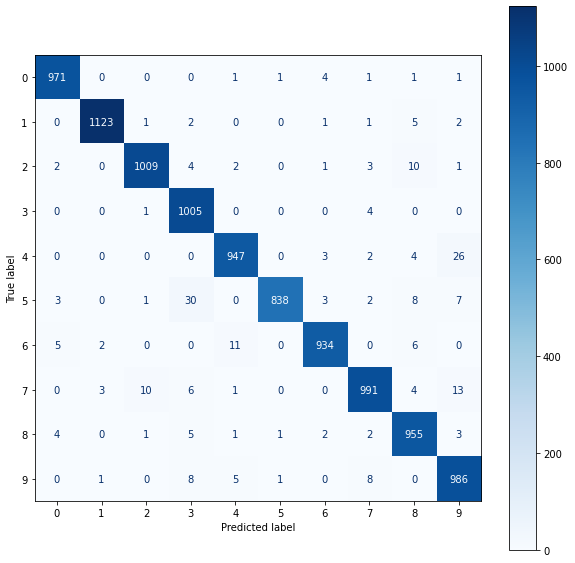

In [ ]:
plot_confusion_matrix(labels, pred_labels)

In [ ]:
#Next for each of our examples, we check if our predicted label 
#Matches our Actual Label 

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
#We can store all of our examples which has incorrect prediction
#

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
#We can plot incorrectly predicted images along with 
#How confident they were on actual label and how confident 
#They were at incorrect label 


In [ ]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace= 0.5)

In [ ]:
#We can see the 25 Incorrect 
#Incorrect and Most Confident about

#The Digits are Irregular 

#We want to train the Model on incredibly confident images


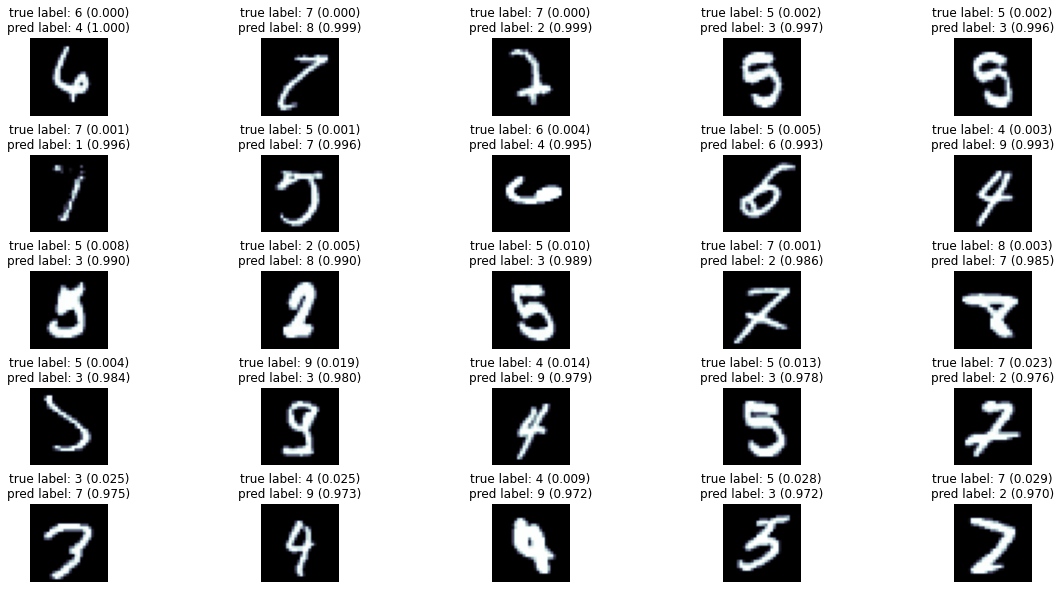

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

In [ ]:
#We can also do is get output 
#Intermediate Representation from Mode
#Try to Visualize Them



In [ ]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    intermediates = torch.cat(intermediates, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, intermediates, labels

In [ ]:
#We run Function to get Representation 


In [ ]:
outputs, intermediates, labels = get_representations(model, train_iterator, device)

In [ ]:
# The Data we want to visualize is in 10 dimension
#And 100 Dimensions 
#We want to get this down to two dimensions
#So we can actually plot it 

#We can use PCA 
#We define a Function to calculate PCA
#Once we do it, We define a function to plot it




In [ ]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [ ]:
def plot_representations(data, labels, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = labels)

In [ ]:
#We plot Represenation from ten dimensional output layer, 
#Reduced to two dimensions

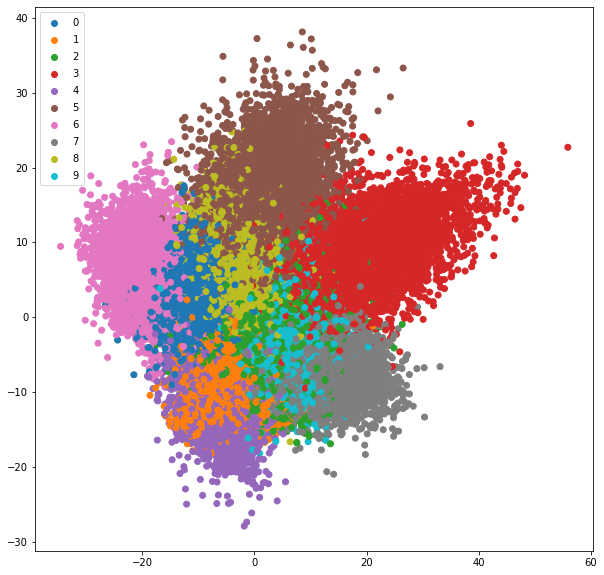

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

In [ ]:
#We plot output of second hidden layer 


In [ ]:
#Intermediate Represenation 


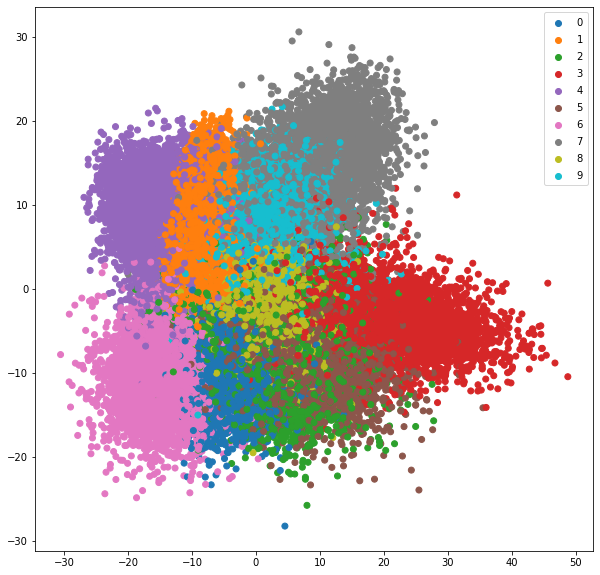

In [ ]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

In [ ]:
#We can use t-SNE (t-distributed stochastic neighbor embedding)


In [ ]:
def get_tsne(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

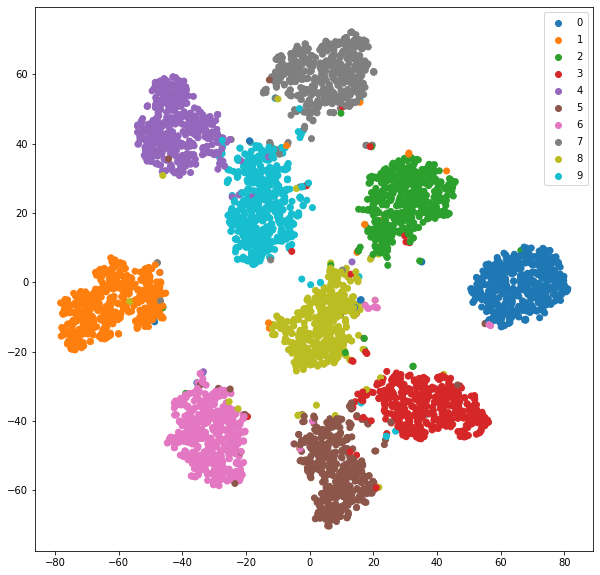

In [ ]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, n_images = N_IMAGES)

In [ ]:
#We plot Intermediate Representation of Same Subset


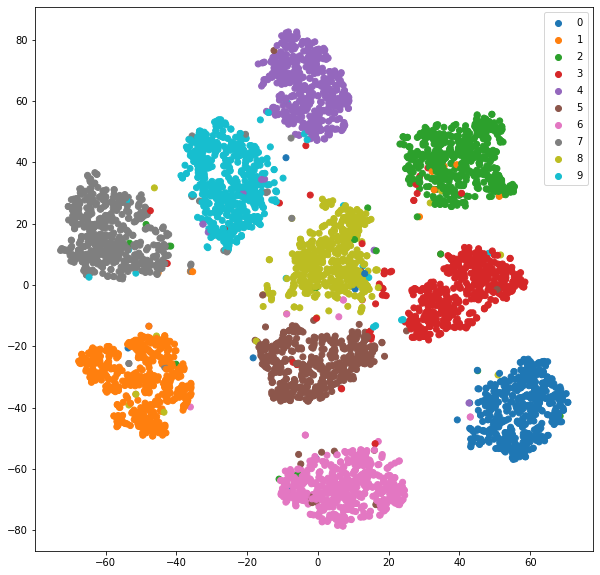

In [ ]:
intermediate_tsne_data = get_tsne(intermediates, n_images = N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images = N_IMAGES)

In [ ]:
#We can also do an experiment 
#We can generate fake digits 
#Function will repeatedly generate random noise 
#Feed it through model and find most confidently generated digit
#For Desired Class

In [ ]:
def imagine_digit(model, digit, device, n_iterations = 50_000):

    model.eval()
    
    best_prob = 0
    best_image = None

    with torch.no_grad():
    
        for _ in range(n_iterations):

            x = torch.randn(32, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim = -1)

            _best_prob, index = torch.max(preds[:,digit], dim = 0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [ ]:
# We can Generate a Perfect Three


In [ ]:
DIGIT = 3

best_image, best_prob = imagine_digit(model, DIGIT, device)

In [ ]:
#We have a digit that model is 100% confident is a three

In [ ]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 100.00%


In [ ]:
#The Perfect three is random noise 
#The Model has been trained 
#Confidently, that it would classify it as something
#It is possible the Model is overfitting trainig data




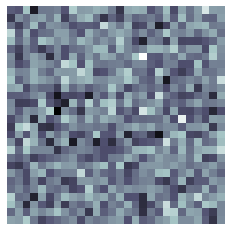

In [ ]:
plt.imshow(best_image.cpu().numpy(), cmap = 'bone')
plt.axis('off');

In [ ]:
#We can plot weights in first layer of our model 

#From One Neuron in First Layer 
#We can learn to look for certain patterns in input

#High Weight Values 
#We plot these weights 
#We might be able to see these patterns


In [ ]:
def plot_weights(weights, n_weights):

    rows = int(np.sqrt(n_weights))
    cols = int(np.sqrt(n_weights))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(weights[i].view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.axis('off')

In [ ]:
#Looking at the Weights
#We see random noise
#Some of them have weird patterns
#Ghostly looking shape, but not images


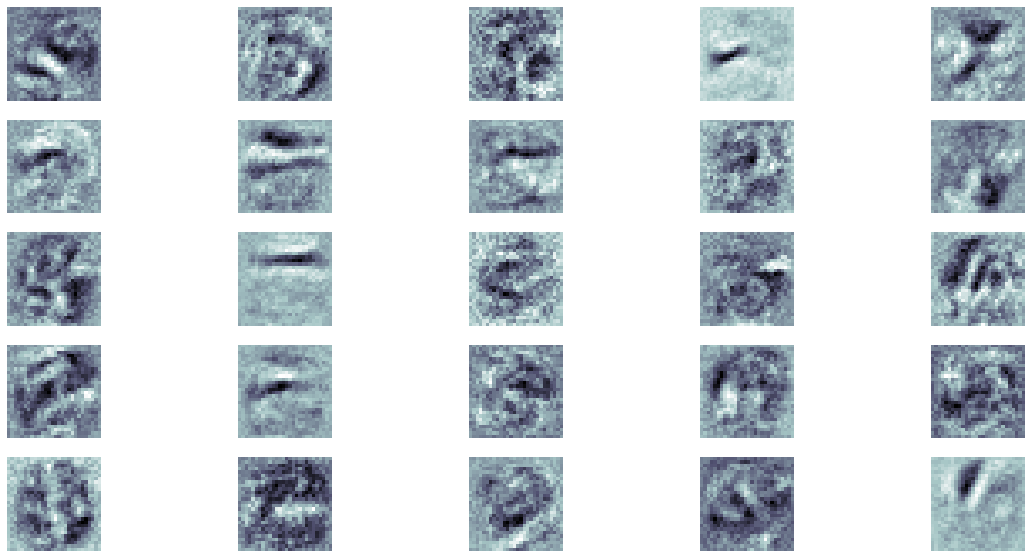

In [ ]:
N_WEIGHTS = 25

weights = model.input_fc.weight.data

plot_weights(weights, N_WEIGHTS)

In [ ]:
#Conclusion

#We have seen Torchvision Dataset

#Loading Transform to Augument and Normalize our Data

#Define a MLP 

#Train a Model to Achieve >97% accuracy 

#Viewing our Model's mistkaes 

#Visualizing our data in lower dimensions with PCA and t-SNE

#Generate Fake digits 

#View the Learnt Weights of our model 

In [ ]:
#Could we try in Iris Dataset? 

#We can implement two layer neural network 
#For Binary Classification 

#Train using Gradient Descent 
#Classify the Iris dataset 




In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#We have list datastructure

#To maintain Model Parameter 
#Gradient 


In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))

class MLP:
    
    def __init__(self, M = 64):
        self.M = M
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v, w = params
            z = logistic(np.dot(x, v)) #N x M
            yh = logistic(np.dot(z, w))#N
            dy = yh - y #N
            dw = np.dot(z.T, dy)/N #M
            dz = np.outer(dy, w) #N x M
            dv = np.dot(x.T, dz * z * (1 - z))/N #D x M
            dparams = [dv, dw]
            return dparams
        
        w = np.random.randn(self.M) * .01
        v = np.random.randn(D,self.M) * .01
        params0 = [v,w]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        v, w = self.params
        z = logistic(np.dot(x, v)) #N x M
        yh = logistic(np.dot(z, w))#N
        return yh

In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params

In [ ]:
#We apply to Iris Dataset 

#We do Binary Classification 

# We run Gradient Descent

#For large number of iterations 

#We plot Decision Boundary 



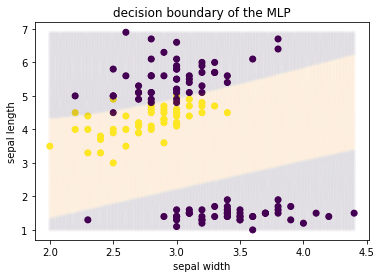

In [ ]:
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,[1,2]], dataset['target']
y =  y == 1
model = MLP(M=32)
optimizer = GradientDescent(learning_rate=.1, max_iters=20000)
yh = model.fit(x, y, optimizer).predict(x) 
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
yh_all = model.predict(x_all) > .5
plt.scatter(x[:,0], x[:,1], c=y, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.title('decision boundary of the MLP')
plt.show()